# Modelos e Estratégias de Trading
## Ajustando um modelo VAR ao Dolar Futuro

Uirá Caiado. 05 de Setembro, 2016

**Resumo**

*Uma das principais necessidades quando falamos trading é realizar algum tipo de previsão sobre o estado futuro do instrumento operado para que possamos posicionar nossas ofertas. Como um dos objetivos da análise de séries temporais multivariadas é a realização de forecasts, nesta atividade vou implementar um modelo desta classe chamado Vetor Auto Regressivo (VAR). Vou ajustar o modelo às informações de book do DOL.*

## 1. Introdução

Quando operamos, frequentemente preciasamos tomar decisões como manter uma posição ou não, comprar, vender, não fazer nada. Se possuírmos uma série temporal de observações relacionadas à variável de interesse (o instrumento ou spread operado, por exemplo) e se estes dados possuírem informação sobre a dinâmica dela, Lutkepohl afirma que é razoável utilizarmos para a previsão alguma função dos dados já coletados, de maneira que:

$$\hat{y}_{K,\, T+1} = f \left( y_{1, T}, y_{2, T}, y_{1, T-1}, \dots \right)$$

Onde $y_{k, t}$ é uma variável aleatória, onde $t$ denota o índice dela no tempo e $k$, o índice da própria variável. A equação de *forecast* acima implica que pode haver interdependência entre as varíaveis utilizadas. Estas multiplas variáveis podem ser os retornos de diferentes ativos, variáveis macro-econômica e etc.

Dado que a série temporal é um conjunto de variáveis aleatórias, assumimos que essa série é gerada por um processo estocástico com um espaço de probabilidade $\left ( \Omega, \, \mathscr{F}, \, P \right )$ associado, onde $\Omega$ é o espaço amostral, $\mathscr{F}$ ou $\sigma-algebra$ representa todos os subconjuntos possíveis de $\Omega$ e $P$, a medida de probabilidade. Definimos que uma variel aleatória é uma função que associa elementos de um espaço amostral $\Omega$ a valores no conjunto de números Reais.

Assim, assumindo que os nossos dados são realizações de variáveis aleatórias, que a mesma processo gerador de dados prevalece sobre todo o período $T$ (ainda que não conhecido), que funções lineares (nos parâmetros) são relativamente fáceis de lidar, podemos escrever um processo auto regressivo vetorial de forma que:

$$y_t = \upsilon + A_q y_{t-1} +  \dots + A_p y_{t-p} + u_t$$

onde $y_t := \left( y_{1t}, \dots, y_{Kt}\right)'$ é um vetor de variáveis aleatórias, $\upsilon := \left( \upsilon_{t}, \dots, \upsilon_{K}\right)'$ é um vetor de constantes, $A$ é uma matriz quadrada de parâmetros e $u_t = \left( u_{1t}, \dots, u_{Kt}\right)$ é uma sequência dops erros de previsão, tidos como *iid* com média $0$. Segundo notas de aula, isto é equivalente a dizer que toda a informação útil contida no  $\sigma-algebra$ foi incorporada ao $y_t$ e não existem erros sistemáticos nos *forecasts*.

Neste trabalho vou estimar os parâmetros do modelo acima, que também é chamado de modelo de vetor auto regressivo (VAR). Dado que é um AR, é esperado que os dados utilizados como input sejam estacionários (primeiro e segundo momento invariante) e que o modelo produzido seja estável (todos os autovalores de $A$ possuem módulo menor do que 1).

Depois vou utilizá-lo para realizar previsões (aqui também referenciados como *forecast*) e estimar os critérios de seleção: erro de predição (FPE), critério de informação de Akaike (AIC), critério de Hannan-Quinn e critério de Schwarz. Por fim, vou ajustar o modelo à alguns dados atuais de mercado.

## 2. Implementando o Modelo

Nesta sessão vou detalhar o processo de estimação dos parâmetros, *forecast* e o cálculo dos critérios de seleção.

### 2.1. Estimando os Parâmetros

Dado que o modelo foi descrito como uma relação linear entre as variáveis, podemos estimar os parâmetros do modelo através da minimização dos erros quadrados (de estimação) utilizando o estimador de mínimos quadrados multivariado. Primeiro, assumindo que a série temporal $y_1, ..., y_T$ de tamanho T e "largura" K (o número de varipaveis disponíveis), de forma que:

                   0         1         2         3         4
2014-01-01  0.004082  0.007782  0.033859  0.023865  0.041760
2014-01-02  0.012377  0.019575  0.052446  0.056654 -0.010573
2014-01-03 -0.006921 -0.011853 -0.005707 -0.017716 -0.019980
2014-01-04  0.000579  0.005753 -0.020576 -0.004274 -0.036814
2014-01-05  0.001156  0.011407 -0.003350  0.003459  0.000000



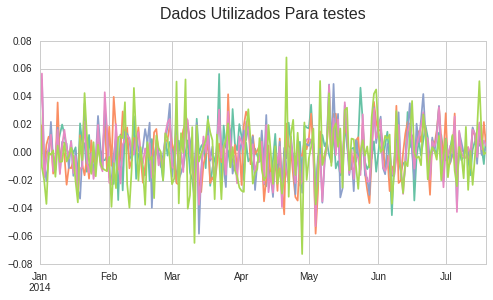

In [231]:
import pandas as pd
df = pd.read_excel('data/VAR3_inputs_e_outputs.xlsx', header=None)
l_index = pd.date_range(start= '01/01/2014', end='01/12/2016')
df.index = l_index[:df.shape[0]]
print df.head()
print
ax = df.plot(legend=False)
ax.set_title('Dados Utilizados Para testes\n', fontsize=16);

In [232]:
df_original = df.copy()

Onde as colunas representam $K$ e as linhas, $T$. Também vamos assumir que os dados utilizandos são estacionários (o que realmente parece, olhando para o gráfico). Definindo:

$$
\begin{aligned}
Y &:= \left(  y_1, \dots, y_T \right)  \;\;\;\;\; &\left(K \times T \right)\\
B &:= \left(  \upsilon,\, A_1 \dots, A_p \right)  \;\;\;\;\; &\left(K \times (Kp + 1) \right)\\
Z_t &:= \left(  1, y_t, \dots, y_{t-p+1} \right)'  \;\;\;\;\; &\left(1 \times (Kp + 1) \right)\\
Z &:= \left(  Z_0, \dots, Z_T \right)  \;\;\;\;\; &\left((Kp + 1) \times T \right)
\end{aligned}
$$

Utilizando notação de mtraiz, reescrevemos o var como sendo da forma $Y = B Z + U$, implicando que os residuos são da forma $U = Y - BZ$. Para determinar o estimador de mínimos quadrados (*Econometric Methods with Application in Business and Economics*, pg. 121), escrevemos a soma do quadrado dos resíduos como:

$$
\begin{aligned}
S(b) &= \sum U^2 = U'U = \left( Y - BZ \right)' \left( Y - BZ \right)\\
     &= Y'Y - Y'BZ - B'Z'Y + B'Z'ZB\\
\end{aligned}
$$

Como $Y'ZB = B'Z'Y$, podemos reescrever a equação acima como:

$$S(b) = Y'Y - 2B'Z'Y + B'Z'ZB$$

Derivando em relação a $B$ e igualando a zero, finalmente chegamos que:

$$
\begin{aligned}
S(b) &= \sum U^2 = U'U = \left( Y - BZ \right)' \left( Y - BZ \right)\\
     &= Y'Y - Y'BZ - B'Z'Y + B'Z'ZB\\
\end{aligned}
$$

Foi criada uma biblioteca chamada *var_model* no repositório deste arquivo implementando este modelo. Os valores serão comparados com os valores obtidos com implementação deste modelo da biblioteca [*statsmodel*](http://statsmodels.sourceforge.net/), do Python. Vamos começar expondo os valores de matriz $B$:

In [9]:
import var_model.vector_autoregression as var
reload(var)
self = var.VectorAutoregression(df)
self.fit(3)

In [32]:
# imprime matrizes A
import pandas as pd
for idx, A in enumerate(self.na_A):
    print "A{}:\n {}".format(idx + 1, pd.DataFrame(A))
    print 
        

A1:
           0         1         2         3         4
0 -0.043374  0.128951 -0.127479  0.049648 -0.071250
1  0.005321  0.178780  0.003759  0.032509 -0.072283
2  0.008242  0.115180 -0.050708  0.007212 -0.041946
3  0.035804  0.166959  0.048654 -0.117873 -0.049864
4 -0.064091 -0.059743 -0.097786  0.268141 -0.054190

A2:
           0         1         2         3         4
0  0.013431  0.001495 -0.242662  0.245055 -0.075217
1 -0.244118 -0.004717 -0.345717  0.413840 -0.032270
2 -0.047898  0.179970 -0.487353  0.295174  0.055272
3 -0.043729  0.159101 -0.365092  0.193884  0.068610
4 -0.028104  0.096378 -0.391956  0.162951 -0.030571

A3:
           0         1         2         3         4
0 -0.044115  0.015434  0.056729 -0.180469  0.065909
1 -0.075600 -0.076008  0.070572  0.017278  0.042417
2 -0.110870  0.027031 -0.034428 -0.013438 -0.022812
3 -0.040539  0.032051 -0.016870 -0.037124 -0.001811
4 -0.046125 -0.081289  0.247950 -0.131097 -0.025088



O matriz $\Sigma_U$ foi estimado direto pela definição $\tilde{\Sigma}_U = \mathbf{E} \left[ u_t u_t '\right]$, ou seja, calculei a matriz $U = Y - BZ$ e fiz o dot product dela por ela transposta e dividi por T (por causa do operador Esperança). Depois ajustei o resultado pelo grau de liberdade do modelo, de maneira que $\hat{\Sigma}_{U} = \frac{T}{T - Kp -1} \tilde{\Sigma}_{U}$.

In [31]:
# imprime matriz Sigma_U
import pandas as pd
print "Sigma_U:\n {}".format(pd.DataFrame(self.na_Sigma))

Sigma_U:
           0         1         2         3         4
0  0.000195  0.000068  0.000056  0.000077  0.000064
1  0.000068  0.000283  0.000154  0.000166  0.000117
2  0.000056  0.000154  0.000309  0.000255  0.000126
3  0.000077  0.000166  0.000255  0.000267  0.000130
4  0.000064  0.000117  0.000126  0.000130  0.000461


Agora vamos comparar estes valores com os valores obtidos pela implementação do *statsmodel*.

In [83]:
from statsmodels.tsa.api import VAR
import statsmodels.tsa.vector_ar.util as util
model = VAR(df)
results = model.fit(3)
aux = util.get_var_endog(df.values, 3)

In [34]:
# calcula erros para implementacao do statsmodel
print "error in Z: {:0.8f}".format(sum(sum(abs(self.na_Z.T - aux))))
print "error in A: {:0.8f}".format(sum(sum(sum(abs(self.na_A - results.coefs)))))
print "error in B: {:0.8f}".format(sum(sum(abs(self.na_betahat - results.params.values))))
print "error in Sigma_U: {:0.8f}".format(sum(sum(abs(self.na_Sigma - results.sigma_u.values))))

error in Z: 0.00000000
error in A: 0.00000000
error in B: 0.00000000
error in Sigma_U: 0.00000000


Como pode-se ver, até a oitava casa decimal, os valores obtidos foram identicos ao obtidos pela biblioteca benchmark.

### 2.2. Forecast

Segundo notas de aula, para se afirmar o que ocorrerá no futuro $\left (  y_1, ..., y_k \right )$, tendo um processo $VAR(p)$ ajustado a um conjunto de dados $\Omega_t = \{ y_s \mid s \leq t \}$ para um horizonte de tempo $h$, precisamos determinar qual o *forecast* ótimo determinando aquele que minimiza uma função custo associada à seus erros (quadráticos médios - MSE na sigla em inglês). O preditor que minimiza estes erros é a esperança condicional (Lutkepohl, p. 33)

$$\mathbf{E}\left [ y_{t+h} \right ] := \mathbf{E}\left [ y_{t+h} \mid  \Omega_t \right ] = \mathbf{E}\left [ y_{t+h} \mid  \{ y_s \mid s \leq t \} \right ]$$

Lutkepohl ainda demonstra que a otimização da esperança condicional impica que:

$$
\mathbf{E}\left [ y_{t+1} \right ] = \upsilon + A_1 y_t + ... + A_p y_{t-p + 1} \\
\mathbf{E}\left [ y_{t+2} \right ] = \upsilon + A_1 \mathbf{E}\left [ y_{t+1} \right ] + A_2 y_t + ... + A_p y_{t-p + 2} \\
\vdots
$$


Aplicando este método e comparando com a implementação benchmark, chegamos que:

In [36]:
my_forecast, my_max, my_min = self.forecast(df[-3:].values, 1)
na_forecast = results.forecast_interval(df[-3:].values, 1)

In [46]:
# previsão para 1 periodo para cada variavel
print "error in Forecast: {:0.8f}\n".format((sum(abs(my_forecast - na_forecast[0][0]))))
print pd.Series(my_forecast)

error in Forecast: 0.00000000

0    0.001801
1    0.006724
2    0.006905
3    0.005442
4    0.000813
dtype: float64


### 2.3. Intervalo de Confiança

Segundo Lutkepohl (p. 38), o erro de previsão (e consequentemente, o intervalo de confiança) pode ser obtido através da matriz de covariância dos erros (ou, da sigla em inglês, MSE matrix). Porém, quando se deseja realizar *forecasts* para mais de um período, é necessário definir também a matriz de coeficientes de Média Móvel (MA), que para um VAR(2) fica:

$$
\phi_1 = A_1 \\
\phi_2 = \phi_1 A_1 + A2 \\
\phi_3 = \phi_2 A_1 + \phi_1 A2 \\
\vdots \\
\phi_i = \phi_{i-1} A_1 + \phi_{i-2} A_2
$$

Assim, a matriz MSE de *forecast* são obtidas recursivamente aplicando

$$
\Gamma_y(0) = \Sigma_y = \sum_{i=0}^{\infty} \phi_i \Sigma_u \phi_i^{'}
$$

Sendo que:
$$
\Sigma_y (1) = \Sigma_u \\
\Sigma_y (2) = \Sigma_u + \phi_{1} \Sigma_u \phi_{1}' \\
\Sigma_y (3) = \Sigma_y (2) + \phi_{2} \Sigma_u \phi_{2}' \\
\vdots
$$

O $h$ em $\Sigma_y (h)$ se refere a quantos passos para frente se aplica a função de forecast. Como o modelo de VAR assume que os erros $u_t \sim N \left( 0, \, \Sigma_y(h) \right)$, podemos assumir que o erro de *forecast* também é normalmente distribuído. Com este pressuposto, podemos definir um [intervalo de confiança](https://en.wikipedia.org/wiki/Confidence_interval) na forma: 
$$\left[ y_{k, \, t} (h) - z_{(\alpha / 2)} \sigma_k (h), \, \, \, \, \, y_{k, \, t} (h) + z_{(\alpha / 2)} \sigma_k (h) \right]$$

Onde $\sigma(h)$ é a raiz quadrada do ** *k-ésimo* elemento da diagonal** $\Sigma_y(h)$. Assim, seguindo exemplo do livro, se tivermos:
$$
\Sigma_y (1) =
\begin{pmatrix}
  \textbf{2.25} & 0 & 0 \\
  0 & \textbf{1.0} & .5 \\
  0 & .5 & \textbf{.74}
\end{pmatrix}
$$

Os intervalos de confiança são dados por:

$$
y_{1, t} (1) \pm z_{(\alpha / 2)} \sqrt{2.25} \\
y_{2, t} (1) \pm z_{(\alpha / 2)} \sqrt{1.0} \\
y_{3, t} (1) \pm z_{(\alpha / 2)} \sqrt{.74}
$$

Assim, vamos calcular os intervalos de confiança para 3 perídos para frente e comparar com a implementação do *benchmark*.

In [47]:
import var_model.vector_autoregression as var
import numpy as np
import pandas as pd
reload(var)
self = var.VectorAutoregression(df)
self.fit(3)

In [48]:
my_forecast, my_max, my_min = self.forecast(df[-5:].values, 3)
na_forecast, na_min, na_max = results.forecast_interval(df[-3:].values, 3)

In [49]:
print "Erro no limite inferior: {:0.7f}".format(sum(abs(na_min[-1] - my_min)))
print "Erro no Forecast: {:0.7f}".format(sum(abs(na_forecast[-1] - my_forecast)))
print "Erro no limite superior: {:0.7f}".format(sum(abs(na_max[-1] - my_max)))
print '\n\n'
df_plot = pd.DataFrame([my_min, na_min[-1]], index=['meu modelo', 'statsmodel'])
df_plot.index.name = 'Minimo'
print str(df_plot)
print ''

df_plot = pd.DataFrame([my_max, na_max[-1]], index=['meu modelo', 'statsmodel'])
df_plot.index.name = 'Maximo'
print df_plot

Erro no limite inferior: 0.0030550
Erro no Forecast: 0.0000000
Erro no limite superior: 0.0030550



                   0         1         2         3         4
Minimo                                                      
meu modelo -0.030019 -0.035569 -0.037285 -0.034497 -0.046392
statsmodel -0.030496 -0.036200 -0.037916 -0.035087 -0.047116

                   0         1         2         3         4
Maximo                                                      
meu modelo  0.026364  0.033363  0.034616  0.032315  0.040077
statsmodel  0.026841  0.033994  0.035248  0.032906  0.040801


Apesar do *forecast* ter ficado igual à implementação do *statsmodel*, os intervalos encontrados foram um pouco diferentes. Porém o erro em relação a implementação do *benchmark* foram simétricos, o que sugere que utilizaram um método de estimação diferente do implementado aqui.

### 2.4. Selecionando a Ordem do VAR

Como visto, além dos dados anteriores, o modelo VAR tem mais uma variável: A ordem do processo auto regressivo. Segundo notas de aula, devemos escolher esta ordem de maneira que as projeções tenham a melhor precisão (ou o menor erro quadrático médio). Lutkepohl argumenta que não há uma única maneira de se fazer isso. Uma opção, por exemplo, é utilizar o critério de erro de predição final (FPE), definido como:

$$FPE(m) = \left[ \frac{T + Km + 1}{T - Km -1} \right]^{K} \left |  \Sigma_u(m) \right | $$

Onde $\left |  . \right |$ é o determinante e $m$ a ordem testada (p. 147, Lutkepohl). Outro critério é O Critério de informação de Akaike (AIC), definido como:

$$AIC(m) = \ln \left |  \Sigma_u(m) \right | + \frac{2mK^2}{T}$$

Uma terceira opção é o Critério de Hannan-Quinn, que possui propriedades amostrais interessantes (consistência, neste caso). Ele é da forma:

$$HQ(m) = \ln \left |  \Sigma_u(m) \right | + \frac{2\ln \ln T}{T}mK^2$$

A última opção implementada será outro com a mesma propriedade assintótica do critério anterior. O critério de Schwarz (SC ou BIC), é da forma:

$$SC(m) = BIC(m) = \ln \left |  \Sigma_u(m) \right | + \frac{\ln T}{T}mK^2$$

In [144]:
import var_model.vector_autoregression as var; reload(var)
import numpy as np
import pandas as pd
self = var.VectorAutoregression(df)

In [145]:
self.select_order(10)

Ordem com menor valor para cada Critério:
  Critério FPE:  		Ord. 1
  Critério AIC:  		Ord. 1
  Critério HQ:  		Ord. 1
  Critério SC(BIC):  		Ord. 1




           AIC  FPE       HQ  SC(BIC)
Ordem                                
1     -42.6786  0.0 -42.5111 -42.2648
2     -42.5899  0.0 -42.2538 -41.7596
3     -42.2861  0.0 -41.7801 -41.0361
4     -42.0422  0.0 -41.3651 -40.3697
5     -41.7619  0.0 -40.9124 -39.6638
6     -41.5320  0.0 -40.5089 -39.0053
7     -41.2570  0.0 -40.0589 -38.2986
8     -40.9928  0.0 -39.6185 -37.5996
9     -40.7496  0.0 -39.1978 -36.9184
10    -40.4579  0.0 -38.7272 -36.1855


## 3. Aplicando o modelo VAR

Nesta seção vamos tentar aplicar o modelo à dado de alta frequência de Dolar Futuro. Os dados serão agrupados em intervalores de 10 segundos e, ao invés de ajustar o modelo aos retornos, o modelo será aplicado à primeira diferença das variáveis selecionadas.

### 3.1. Order Flow Imbalance

Cont at all argumenta que os eventos do book - ordens a mercado, ordens limite e cancelamentos - impactam na dinâmica do preço do ativo e que este impacto pode ser modelado através de uma única variável: o *order flow imbalance* (OFI), que representa o *net* de quantidade que entrou e saiu das filas do bid e do ask. Assim, para cada evento $e_n$ no Book de ofertas:

$$e_n = \mathbb{1}_{P_{n}^{B} \geq P_{n-1}^{B}} q^{B}_{n} - \mathbb{1}_{P_{n}^{B} \leq P_{n-1}^{B}}  q^{B}_{n-1} - \mathbb{1}_{P_{n}^{A} \leq P_{n-1}^{A}} q^{A}_{n} + \mathbb{1}_{P_{n}^{A} \geq P_{n-1}^{A}}  q^{A}_{n-1}$$

Onde $q^{B}_{n}$, $q^{A}_{n}$ se refere a quantidade no melhor preço no Bid e no Ask, respectivamente no período atual $n$. O subscrito $n-1$ se refere ao estado anterior. $\mathbb{1}$ é uma função [Indicadora](https://en.wikipedia.org/wiki/Indicator_function). Como os eventos que afetam o book acontecem em tempos $\tau_n$ aleatórios, definimos $N(t) = \max \{ n \mid \tau_n \leq t \}$ o número de eventos que ocorreram entre $\left [ 0, \, t\right ]$. A variável OFI é definida sobre o intervalo $\left [ t_{k-1}, \, t_k\right ]$ e é a soma de cada $e_n$ que ocorreu neste período, de maneira que:

$$OFI_k = \sum^{N(t_k)}_{n=N(t_{k-1})+1} e_n$$

Eles alegam que esta variável consegue explicar utilizando uma relação linear simples a mudança no mid-price em curtos espaços de tempo. A intuição, segundo eles, é que "precisa de volume para movimentar o preço". A mudança no mid-price, no estudo deles, é definido em ticks. Assim:

$$\Delta P_k = \frac{\left( P_k - P_{k-1}\right)}{\delta}$$

Onde $\delta$ é o tamanho do tick do instrumento analisado.

### 3.2. Computando o OFI do DOL

Vamos começar computando o OFI para dois dias de [dados de Nível I](http://www.investopedia.com/terms/l/level1.asp) do book do contrato DOLV16. Primeiro, vamos checar o tamnho do arquivo

In [ ]:
import var_model.vector_autoregression as var; reload(var)
import numpy as np
import pandas as pd

In [4]:
import zipfile
s_fname = "data/20160913_dol.zip"
archive = zipfile.ZipFile(s_fname, 'r')
def foo():
    f_total = 0.
    f_tot_rows = 0.
    for i, x in enumerate(archive.infolist()):
        f_total += x.file_size/ 1024.**2
        for num_rows, row in enumerate(archive.open(x)):
            f_tot_rows += 1
        print "{}:\t{:,.0f} rows\t{:0.2f} MB".format(x.filename, num_rows + 1, x.file_size/ 1024.**2)

%time foo()

20160913_dol.txt:	756,137 rows	24.60 MB
CPU times: user 2.14 s, sys: 0 ns, total: 2.14 s
Wall time: 2.14 s


Agora, vamos calcula linha por linha o valor do $e_n$ e acumulá-lo por 10 segundos. Cada vez que passar deste tempo, vou imprimir o dado acumulado em um novo arquivo e zerar os valores. Também vou parear estes dados com a mudança no mid-price do ativo, já noromalizado pelo tick-size (de meio ponto). Também vou guardar o log retorno nestes 10 segundos.

In [3]:
def measure_e_n(row, last_best):
    '''
    Measure the e_n of the current event
    :param row: dictionary. current row from the file
    :param last_best: tuple. best price and best quantity
    '''
    e_n = 0
    if row['Type'] == 'BID':
        e_n += (row['Price'] >= last_best[0]) * row['Size']
        e_n -= (row['Price'] <= last_best[0]) * last_best[1]
    elif row['Type'] == 'ASK':
        e_n -= (row['Price'] <= last_best[0]) * row['Size']
        e_n += (row['Price'] >= last_best[0]) * last_best[1]
    return e_n

def convert_float_to_time(f_time):
    '''
    Converst number of seconds in string time format
    '''
    i_hour = int(f_time / 3600)
    i_minute = int((f_time - i_hour * 3600) / 60)
    i_seconds = int((f_time - i_hour * 3600 - i_minute *60 ))
    return '{:02d}:{:02d}:{:02d}'.format(i_hour, i_minute, i_seconds)

In [591]:
import zipfile
import csv
import time
f_start = time.time()
s_fname = "data/20160913_dol.zip"
fw_out = open('data/ofi_dol.txt', 'w')
fw_out.write('TIME\tOFI\tDELTA_MID\tLOG_RET\n')
archive = zipfile.ZipFile(s_fname, 'r')
f_total = 0.
f_tot_rows = 0.
d_best_price = {'BID': (0., 0.), 'ASK': (0., 0.)}
f_min_time = 10.  # em segundos
for i, x in enumerate(archive.infolist()):
    # le cada arquivo dentro do arquivo zip (neste caso, ha apenas 1 arquivo)
    f_ofi = 0.
    f_mid = None
    f_next_time = 9 * 3600 + f_min_time
    for idx_row, row in enumerate(csv.DictReader(archive.open(x), delimiter='\t')):
        if idx_row == 0:
            f_first_price = row['Price']
        # nao preciso lidar com os trades, pois jah esta refletido no bid e ask
        if row['Type'] in ['BID', 'ASK']:
            # converte string para float
            row['Price'] = float(row['Price'].replace(',', '.')) 
            row['Size'] = float(row['Size'])
            f_current_time = sum([float(x)*60**(2.-i_aux)  for i_aux, x in enumerate(row['Date'][-8:].split(":"))])
            if f_current_time > f_next_time:
                # imprime resultado
                s_time = convert_float_to_time(f_next_time)
                f_change = 0
                f_logrtn = 0.
                if f_mid:
                    f_curent_mid = (d_best_price['ASK'][0] + d_best_price['BID'][0])/2.
                    f_change = int((f_curent_mid - f_mid)/0.5)
                    f_logrtn = np.log((f_curent_mid/f_mid))
                f_mid = (d_best_price['ASK'][0] + d_best_price['BID'][0])/2.
                s_out = '{}\t{}\t{}\t{}\n'.format(s_time, f_ofi, f_change, f_logrtn)              
                fw_out.write(s_out)
                # zera valor
                f_ofi = 0
                 # imprime de 10 em 10 s
                f_next_time  = (int(f_current_time/f_min_time) + 1)*f_min_time
            elif abs(f_current_time - f_next_time) > 3600:
                # new day
                f_next_time = 9 * 3600
                f_mid = None
                f_ofi = 0
            # compara com valor anterior
            last_best = d_best_price[row['Type']]
            f_e_n = measure_e_n(row, last_best)
            # atualiza last best
            d_best_price[row['Type']] = (row['Price'], row['Size'])
            row['Date'] = row['Date'][-8:]
            f_ofi += f_e_n
            
            
             
    
print 'Tempo para processar: {:0.2f} s'.format(time.time() - f_start)

Tempo para processar: 19.56 s


Vamos dar uma olhada em como ficaram os dados

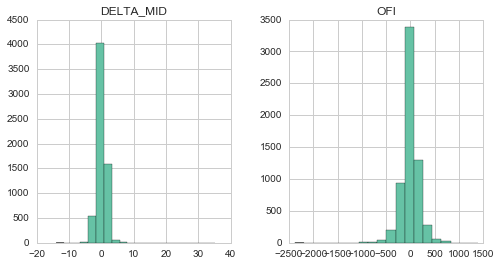

In [2]:
import pandas as pd
df = pd.read_csv('data/ofi_dol.txt', sep='\t')
df.drop('TIME', axis=1, inplace=True)
df.dropna(inplace=True)
ax = df[['OFI', 'DELTA_MID']].hist(bins=20);

Parece que temos alguns outliers. Vamos excluir os pontos mais extremos. Para classificar estes pontos, vou calcular o valor entre os percentis 1 e 90 e checar quais pontos ficam fora de 1.5 vezes este intervalo além dos percentis citados.

In [3]:
import numpy as np
# Para cada colouna, acha valores extremos maximos e minimos
d_unique_idx = dict()
d_iqr = {}
print u"Número de ponto de dados considerado outlier para a variável\n"
for feature in df.keys():
    
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(df[feature], 1)
    
    # Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(df[feature], 90)
    
    # calcula intervalo interquartil e calcula o tamanho para ser outlier
    d_iqr[feature] = (Q3-Q1)
    step = 1.5*(Q3-Q1)
    
    # Mostra outliers
    df_out_lier = df[~((df[feature] >= Q1 - step) & (df[feature] <= Q3 + step))]
    i_nfeatures = df_out_lier.shape[0]
    print "{:18s}\t{:18s}".format(feature, str(i_nfeatures))
    for x in df_out_lier.index:
        if x not in d_unique_idx.keys():
            d_unique_idx[x] = 1
        else:
            d_unique_idx[x] += 1

print "-------------------------"
print u"TOTAL: Outliers: {} | Outliers Únicos: {}".format(sum(d_unique_idx.values()),
                                                          len(d_unique_idx.keys()))
# filtra dados considerados outliers
print u"\n\nPontos considerados outliers:"
df.ix[d_unique_idx.keys(), :]

Número de ponto de dados considerado outlier para a variável

OFI               	2                 
DELTA_MID         	6                 
LOG_RET           	4                 
-------------------------
TOTAL: Outliers: 12 | Outliers Únicos: 7


Pontos considerados outliers:


,OFI,DELTA_MID,LOG_RET
3176,265.0,35.0,0.005345
10,835.0,8.0,0.001204
11,655.0,9.0,0.001428
4782,1395.0,7.0,0.001122
6036,1025.0,12.0,0.001875
1881,-2380.0,-14.0,-0.002128
3132,675.0,8.0,0.001302


Agora, vamos plotar o scatter plot dos dados sem os pontos acima

In [4]:
df2 = df.loc[[x for x in df.index if x not in d_unique_idx.keys()]]

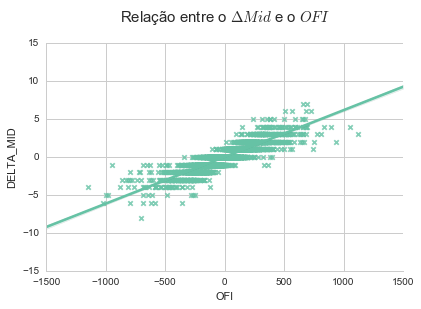

In [5]:
ax = sns.lmplot(x="OFI", y="DELTA_MID", data=df2, markers=["x"], palette="Set2", size=4, aspect=1.5)
ax.ax.set_title(u'Relação entre o $\Delta Mid$ e o $OFI$\n', fontsize=15);

Como era esperado, há uma relação linear clara entre o volume que entrou ou saiu do book e a mudança de prço do ativo, quando considerado um intervalo curto de tempo. Na próxima seção, vou usar esta variável para tentar melhorar o resultado do modelo VAR para fazer *forecast* do retorno do DOLV16.

### 3.3. Ajustando um modelo VAR aos dados calculados

Primeiro, é necessário checar se as variáveis são estacionárias. Porém, faremos isso apenas visualmente aqui. 

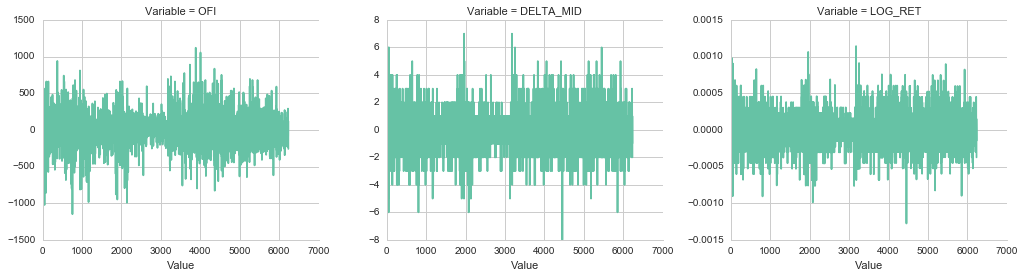

In [11]:
import matplotlib.pyplot as plt
df_plot = df2.unstack().reset_index()
df_plot.drop('level_1', axis=1, inplace=True)
df_plot.columns = ['Variable', 'Value']
g = sns.FacetGrid(df_plot, col="Variable", sharey=False,  size=4, aspect=1.2)
g = g.map(plt.plot, "Value")

A média parece ser constante, já o desvio padrão não deve ser. Note também que todas as variáveis tem escala diferente. Agora, vamos ver qual a melhor ordem de VAR se ajusta a estes dados (desconsiderando o log retorno).

In [12]:
df3 = df2.copy()
# df3/=pd.Series(d_iqr)
# df3['OFI'] /= d_iqr['OFI']  # normaliza valores de OFI

In [13]:
import var_model.vector_autoregression as var; reload(var)
import numpy as np
import pandas as pd
self = var.VectorAutoregression(pd.DataFrame(df3[['OFI', 'DELTA_MID']]))
self.select_order(18)

Ordem com menor valor para cada Critério:
  Critério FPE:  		Ord. 16
  Critério AIC:  		Ord. 16
  Critério HQ:  		Ord. 6
  Critério SC(BIC):  		Ord. 1




          AIC     FPE      HQ  SC(BIC)
Ordem                                 
1      9.2636  1.6930  9.2651   9.2680
2      9.2636  1.6927  9.2666   9.2723
3      9.2573  1.6818  9.2618   9.2703
4      9.2544  1.6766  9.2604   9.2717
5      9.2504  1.6697  9.2579   9.2720
6      9.2487  1.6666  9.2577   9.2747
7      9.2489  1.6667  9.2594   9.2792
8      9.2494  1.6672  9.2614   9.2840
9      9.2497  1.6675  9.2633   9.2887
10     9.2501  1.6679  9.2651   9.2934
11     9.2498  1.6671  9.2663   9.2975
12     9.2499  1.6669  9.2679   9.3018
13     9.2487  1.6647  9.2682   9.3050
14     9.2502  1.6669  9.2712   9.3108
15     9.2482  1.6634  9.2708   9.3132
16     9.2459  1.6593  9.2700   9.3153
17     9.2479  1.6623  9.2734   9.3216
18     9.2482  1.6625  9.2752   9.3262


Os critérios indicaram ordens diferentes. Vamos ver como ficam as projeções com um modelo de ordem 16, inicialmente.

In [17]:
reload(var)

def measure_on_data(i_var_order, l_col):
    var_6 = var.VectorAutoregression(df3[l_col])
    var_6.fit(i_var_order)
    l_rtn = []
#     f_val = float(f_first_price.replace(',', '.'))
    f_val = 0
    df4 = df3[l_col].reset_index(drop=True)
    l_label = df4.columns
    for i_idx in xrange(i_var_order, df4.shape[0]):
        na_y = df4.ix[(i_idx-i_var_order):i_idx-1, :].values
        na_rtn, na_max, na_min= var_6.forecast(na_y, 1)
        na_yr = df4.ix[i_idx, :]

        d_aux = {'ID': i_idx}
        for x in xrange(len(l_label)):
            d_aux[l_label[x] + '_OBSV'] = na_yr[x]
            d_aux[l_label[x] + '_FORC'] = na_rtn[x]
            d_aux[l_label[x] + '_MAX'] = na_max[x]
            d_aux[l_label[x] + '_MIN'] = na_min[x]

        l_rtn.append(d_aux)

    df_test = pd.DataFrame(l_rtn)
    df_test.index = df_test['ID']
    df_test.drop('ID', axis=1, inplace=True)
    
    return df_test

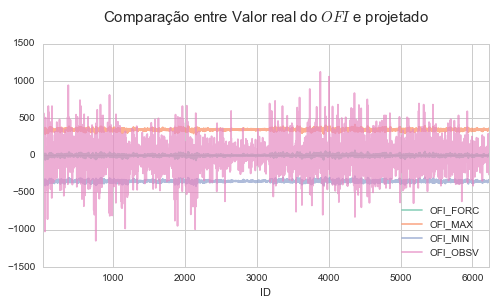

In [24]:
df_test = measure_on_data(16, l_col=['OFI'])
ax = df_test.plot(alpha=0.7)
ax.set_title(u'Comparação entre Valor real do $OFI$ e projetado\n', fontsize=15);

Note que o valor projetado ($OFI\_FORC$) ficou distante do observado. Assim, ao invés de olharmos para o valor projetado, vamos nos concentrar no sinal dos valores e checar se a projeção apontou para o mesmo lado do realizado. Abaixo vou plotar o percentual de vezes que o modelo acertou o lado de mercado, ajustando várias um VAR de diferentes ordens há combinaçòes de variáveis diferentes. O objetivo é sempre prever a primeira variável de cada linha, de acordo com a legenda.

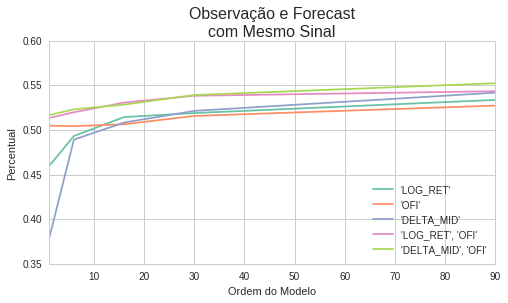

In [658]:
ax = None
for l_col in [['LOG_RET'], ['OFI'], ['DELTA_MID'], ['LOG_RET', 'OFI'], ['DELTA_MID', 'OFI']]:
    d_rtn = {}
    l_orders_to_test = [1, 6, 16, 30, 90]  # 10 seg, 40 seg, 2 min e 40 seg, 5 min, 15 min
    for i_ord in l_orders_to_test:
        df_test = measure_on_data(i_ord, l_col=l_col)
        d_rtn[i_ord] = ((df_test[l_col[0] + '_FORC'] / df_test[l_col[0] + '_OBSV'])>=0).sum() * 1. / df_test.shape[0]

    if not ax:
        ax = pd.Series(d_rtn).plot(ax=ax, label = str(l_col)[1:-1])
    else:
        pd.Series(d_rtn).plot(label = str(l_col)[1:-1])
ax.set_title(u'Observação e Forecast\ncom Mesmo Sinal', fontsize=16)
ax.legend(loc='lower right')
ax.set_xlabel('Ordem do Modelo')
ax.set_ylabel('Percentual');

Quando um modelo VAR foi ajustado apenas à uma variável, o que melhor se saiu em ordens baixas foi o ajustado para prever o OFI, acertando o da próxima observação desta variável em pouco mais de 50% das vezes. Porém, quando aumentamos a ordem do modelo, os modelos ajustados ao log retorno e ao delta-mid  superarm o modelo ajustado apenas ao OFI. Já quando usamos mais de uma variável, os modelos utilizando o OFI e o mid-price ou o OFI e o log-retorno apresentaram desempenho semelhante em modelos de ordem até 50, chegando perto de acertarem a direção do mercado em quase 55% das vezes. Porém, em ordens mais altas, o modelo que utilizou o OFI e o delta-mid foi o que melhor se saiu, superando 55% de acerto.


## 4. Conclusão

Os testes com modelo VAR utilizando as variáveis propostas para dados de alta frequência indicaram ele é pouco adequado se for necessários fazer *forecasts* precisos. Porém, ao considerarmos a direção do sinal dado pelo modelo, os resultados sugerem que este pode ser uma ferramenta útil no contexto de *trading*.


## 5. Últimas Considerações

Seria interessante realizar um back-test com os modelos criados e tentar agregar mais variáveis para tentar melhorar o percentual de acerto deles.

## Referências

1. H. Lütkepohl.  *New Introduction to Multiple Time Series Analysis*. Springer-Verlag, 2005. [*link*](http://www.springer.com/br/book/9783540401728)
2. Heij, C. and de Boer, P. and Franses, P.H. and Kloek, T. and van Dijk, H.K. and Rotterdam.  *Econometric Methods with Applications in Business and Economics*. OUP Oxford, 2004. [*link*](https://books.google.com.br/books?id=hp4vQZZHfbUC)
3. Cont, R. and Kukanov, A. and Stoikov.  *The Price Impact of Order Book Events*. Journal Of Financial Econometrics, 2014. [*link*](http://ssrn.com/abstract=1712822)


*Style notebook and change matplotlib defaults*

In [25]:
#loading style sheet
from IPython.core.display import HTML
HTML(open('ipython_style.css').read())

In [1]:
#changing matplotlib defaults
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Set2", 10))